# Задание 5: Реализация функций расстановки (хеширование) и различных методов разрешения коллизий
## Вариант 5: разрешение коллизий методом квадратичного опробирования

Реализовывать хеш-таблицу будем через собственную реализацию классу, содержащую поле `items`, массив объектов хеш-таблицы.

Для начала, импортируем необходимые библиотеки.

Библиотека `hashlib` позволяет использовать популярные хеш-функции. В частности, в этом задании мы будем использовать MD5, SHA-1 и SHA-224. Библиотека `numpy` даст нам бэкенд для создания массива данных, а `jdc` позволит динамически добавлять элементы класса в разных ячейках этой jupyter-тетради.

In [1]:
import hashlib
import numpy as np
import jdc

Начнем описывать непосредственно класс. Хэширование реализуем уже внутри этого класса при автоматическом индексировании объектов.

`__init__` - конструктор объектов класса; имеет параметры:
* `size_of_db` - количество объектов создаваемом объекте
* `size_of_value` - величина одного объекта
* `hash_type` - определение функции хеширования объекта. Доступны три варианта: `md5`, `sha1`, `sha224`.

In [2]:
class Database:
    def __init__(self, size_of_db, size_of_value, hash_type='md5'):
        self.size_of_db = size_of_db
        self.size_of_value = size_of_value
        self.items = np.chararray(size_of_db, size_of_value)
        self.items[:] = ''
        self.hash_type = hash_type

Определения принципа итерирования по объекту:

In [3]:
%%add_to Database
def __iter__(self):
    for i in self.items:
        yield i

Непосредственно функции хеширования данных. Одна из этих функций используется в созданном объекте при добавлении объекта.

In [4]:
%%add_to Database
def hash_md5_to_int(s):
    return int(hashlib.md5(s.encode('utf-8')).hexdigest(), 16)

def hash_256(s):
    return int(s) % 256

def hash_65536(s):
    s = int(s)
    s = s * 77
    s = s // 20.48
    s = s * (s % 256)
    s = int(s)
    return s % 65536

Добавление объектов в базу данных. В теле функции вызывает функция запроса ключа по высчитыванию хеша от значения добавляемого объекта.

In [5]:
%%add_to Database
def add(self, value):
    self.items[self.get_key(value)] = value

Функция удаления значения из базы данных. За один запрос удаляет все значения, вне зависимости от их положения.

In [6]:
%%add_to Database
def delete(self, value):
    for i in range(self.items.shape[0]):
        if self.items[i] == value.encode('utf-8'):
            self.items[i] = ''

Возвращает позицию первого встретившегося объекта со значением, равным запрошенному.

In [7]:
%%add_to Database
def find(self, value):
    for i in range(self.items.shape[0]):
        if self.items[i] == value.encode('utf-8'):
            return i

Функция получает значения ключа для добавления объекта по запрошенному значению. В функции реализовано разрешение коллизий путем квадратичного пробирования.

In [8]:
%%add_to Database
def get_key(self, value):
    C1 = 0.5
    C2 = 0.5
    if self.hash_type == 'md5':
        hashed = Database.hash_md5_to_int(value)
    elif self.hash_type == '256':
        hashed = Database.hash_256(value)
    elif self.hash_type == '65536':
        hashed = Database.hash_65536(value)
    else:
        raise AttributeError
    current_key = hashed % self.items.shape[0]
    i = 0
    while not (self.items[current_key] == ''):
        i += 1
        current_key = (hashed + int(C1 * i + C2 * i * i)) % self.items.shape[0]
        if i > len(self.items):
            raise Exception
    return current_key

Проврим созданный класс. Создадим объект `db`, добавим в него несколько объектов, составляющих коллизии, а также пару иных.

In [9]:
db = Database(32, 16, 'md5')
db.add('asd')
db.add('asd')
db.add('asd')
db.add('qwe')
db.add('zxc')
print(db.items)

['' '' '' '' '' '' b'qwe' b'zxc' '' '' '' '' '' '' b'asd' b'asd' '' b'asd'
 '' '' '' '' '' '' '' '' '' '' '' '' '' '']


Как видно, метод разрешния коллизий корректно работает.

Попробуем получить элемент хеш-таблицы по значению, получив ключ от значения и обратившись к нему.

In [10]:
print(db.items[db.find('asd')])

b'asd'


Попробуем удалить все объекты со значением `'asd'` из объекта `db`. Мы должны получить объект, содержащий только строки `'qwe'` и `'zxc'`

In [11]:
db.delete('asd')
print(db.items)

['' '' '' '' '' '' b'qwe' b'zxc' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '']


Все функции корректно обрабатывают объект, следовательно, класс корректно реализован.

Теперь оценим последовательно каждую из хеш-функций, использованных прежде. Для этого будем последовательно заполнять ассоциативный массив значениями с ключами, равными значениям хеш-функций. В случае, если в таблице уже есть значение под таким ключом, будем считать это коллизией. Подсчитаем такие коллизии для массивов различных размеров.

Для начала, импортируем библиотеке, которые будем позже использовать.

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import hashlib
import numpy as np
from tqdm import tqdm_notebook

Теперь повторно опишем каждую из функций шифрования.

In [13]:
def hash_256(s):
    return int(s) % 256

def hash_65536(s):
    s = int(s)
    s = s * 77
    s = s // 20.48
    s = s * (s % 2356)
    s = int(s)
    return s % 65536 * len(str(s))

def hash_md5(s):
    s = str(s)
    s = s.encode('utf-8')
    return int(hashlib.md5(s).hexdigest(), 16)

Зададим размеры пределов количества хешируемых объектов

In [14]:
SIZE = [50, 100, 250, 500, 1000, 2500, 10000, 15000, 25000, 50000, 100000, 200000]

Теперь последовательно проверим количество коллизий всех функций на различных количествах объектов

Функция `hash_256`:

In [15]:
results_256 = []
for i in tqdm_notebook(SIZE):
    a = {}
    collision_counter = 0
    for j in range(i):
        hashed = hash_256(j)
        try:
            if a[hashed]:
                collision_counter += 1
        except KeyError:
            a[hashed] = True
    results_256.append(collision_counter)

HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

In [16]:
results_256

[0, 0, 0, 244, 744, 2244, 9744, 14744, 24744, 49744, 99744, 199744]

Функция `hash_65536`:

In [17]:
results_65536 = []
for i in tqdm_notebook(SIZE):
    a = {}
    collision_counter = 0
    for j in range(i):
        hashed = hash_65536(j)
        try:
            if a[hashed]:
                collision_counter += 1
        except KeyError:
            a[hashed] = True
    results_65536.append(collision_counter)

HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

In [18]:
results_65536

[0, 0, 0, 0, 8, 100, 1259, 2543, 5363, 16481, 53343, 135063]

Функция `hash_md5`:

In [19]:
results_md5 = []
for i in tqdm_notebook(SIZE):
    a = {}
    collision_counter = 0
    for j in range(i):
        hashed = hash_md5(j)
        try:
            if a[hashed]:
                collision_counter += 1
        except KeyError:
            a[hashed] = True
    results_md5.append(collision_counter)

HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

In [20]:
results_md5

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Теперь построим графики количества коллизий в зависимости от размера массива:

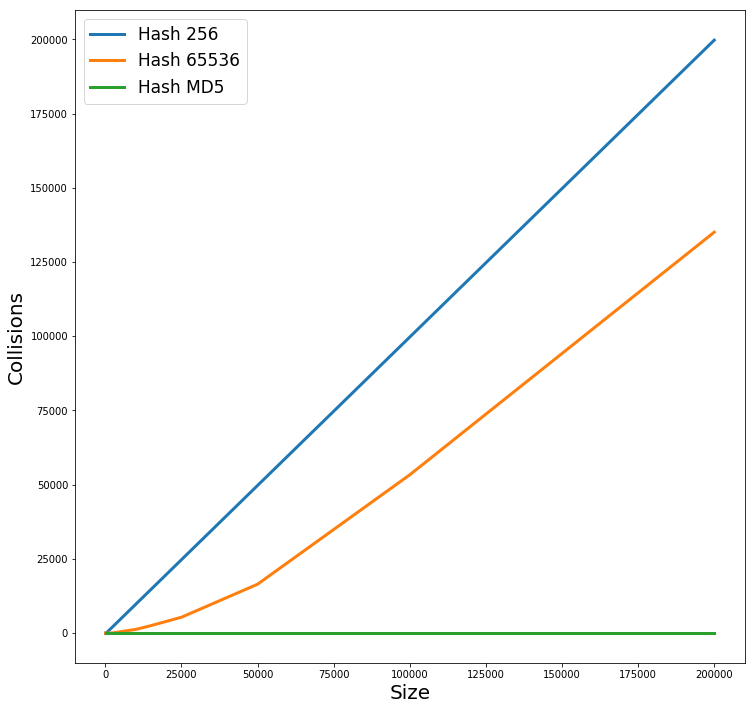

In [21]:
plt.figure(figsize=(12,12))
plt.xlabel('Size', fontsize=20)
plt.ylabel('Collisions', fontsize=20)

line_256, = plt.plot(SIZE, results_256, linewidth=3, label='Hash 256')
line_65536, = plt.plot(SIZE, results_65536, linewidth=3, label='Hash 65536')
line_md5, = plt.plot(SIZE, results_md5, linewidth=3, label='Hash MD5')

plt.legend(handles=[line_256, line_65536, line_md5], fontsize=17)

Очевидно, что из представленных хеш-функций MD5 является наиболее эффективной.